In [1]:
import math
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import IPython.display as disp
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import transforms
from compressai.models import CompressionModel
from compressai.entropy_models import EntropyBottleneck
from compressai.models.utils import conv, deconv
from compressai.layers import GDN

In [2]:
dataset = load_dataset("danjacobellis/danjacobellis_AVIRIS_256",split='train').with_format("torch")

In [3]:
class RateDistortionAutoEncoder(CompressionModel):
    def __init__(self, N=128):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            conv(224, N),
            GDN(N),
            conv(N, N),
            GDN(N),
            conv(N, N),
        )

        self.decode = nn.Sequential(
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, 224),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [4]:
def live_plot(x):
    plt.clf()
    plt.plot(x)
    disp.display(plt.gcf())
    disp.clear_output(wait=True)

In [5]:
net = RateDistortionAutoEncoder().to("cuda")
parameters = set(p for n, p in net.named_parameters() if not n.endswith(".quantiles"))
aux_parameters = set(p for n, p in net.named_parameters() if n.endswith(".quantiles"))
optimizer = optim.AdamW(parameters, lr=1e-4)
aux_optimizer = optim.AdamW(aux_parameters, lr=1e-3)
λ = 0.01

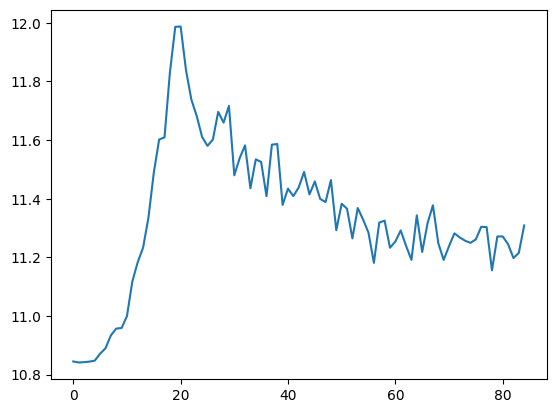

In [6]:
rate = np.array([])
distortion = np.array([])
for i_epoch in range(5):
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    for i,batch in enumerate(dataloader):
        optimizer.zero_grad()
        aux_optimizer.zero_grad()
    
        x = batch['hyperspectral'].to("cuda")
        x = x.to(torch.float)
        
        x_hat, y_likelihoods = net(x)
        
        # bitrate of the quantized latent
        N, _, H, W = x.size()
        num_pixels = N * H * W
        bpp_loss = torch.log(y_likelihoods).sum() / (-math.log(2) * num_pixels)
        rate = np.append(rate,bpp_loss.detach().cpu().numpy())
        
        # mean square error
        mse_loss = F.mse_loss(x, x_hat)
        distortion = np.append(distortion,mse_loss.detach().cpu().numpy())
        
        # final loss term
        loss = mse_loss + λ * bpp_loss
        
        loss.backward()
        optimizer.step()
        
        aux_loss = net.aux_loss()
        aux_loss.backward()
        aux_optimizer.step()

        torch.save({
                'epoch': i,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'aux_optimizer_state_dict': aux_optimizer.state_dict(),
                'loss': loss,
            }, f"rdae_AVIRIS_checkpoint.pth")
        live_plot(rate)
        np.save('rate',rate)
        np.save('distortion',distortion)